### 特征值处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import feather

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
df = feather.read_dataframe('data10009.feather')

In [3]:
# 去除无法数字化的值
df = df.drop(['customer_ID','S_2','D_63','D_64'],axis=1)

In [4]:
# 检查是否有空值
df_num = df.isnull().sum()

In [5]:
df_num

P_2         53
D_39         0
B_1          0
B_2          1
R_1          0
          ... 
D_142     8235
D_143      183
D_144       85
D_145      183
target       0
Length: 187, dtype: int64

In [6]:
# 每一列空值的数量
df_num = df_num[df_num!=0]
xy = pd.DataFrame({'x':df_num.sort_values().index.tolist(),'y':df_num.sort_values().tolist()})

Text(0, 0.5, 'Count')

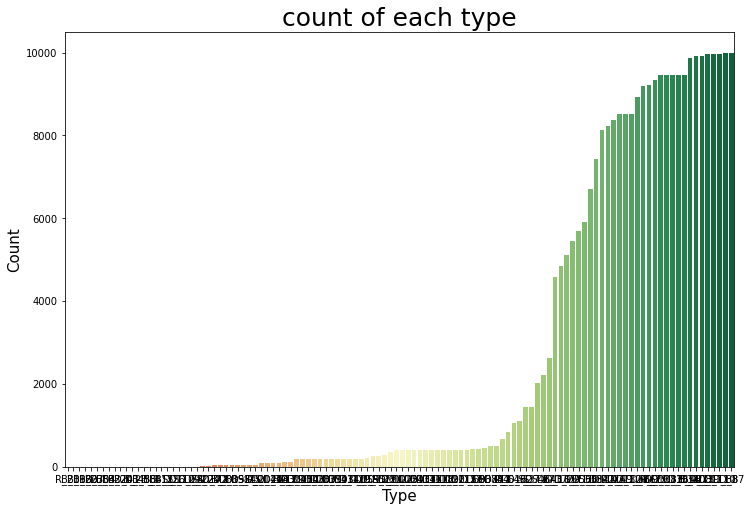

In [7]:
# 画图展示每一列空值的数量
plt.figure(figsize=(12,8))
sns.barplot(x='x',y='y',data=xy,palette='RdYlGn')
plt.title('count of each type',fontsize=25,fontweight=5)
plt.xlabel('Type',fontsize=15,fontweight=3)
plt.ylabel('Count',fontsize=15,fontweight=3) 

In [8]:
# 根据上图分析 删除空值数量大于1000的列
df = df.drop(df_num[df_num > 1000].index.tolist(),axis=1)

Text(0, 0.5, 'Count')

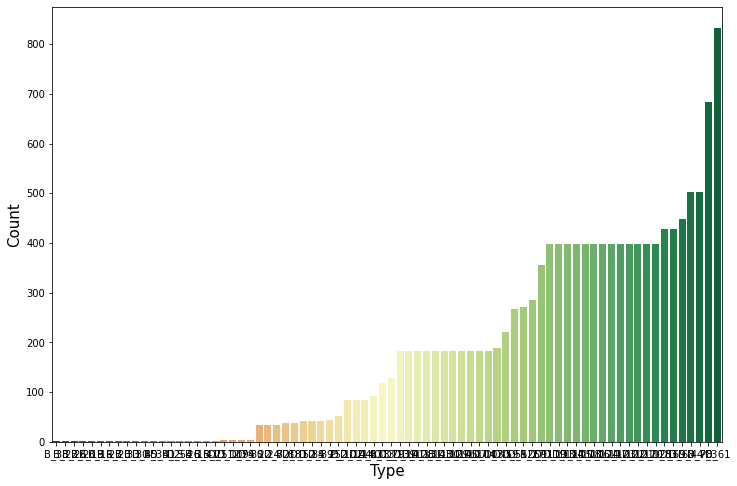

In [9]:
df_num = df.isnull().sum()
df_num = df_num[df_num!=0]
xy = pd.DataFrame({'x':df_num.sort_values().index.tolist(),'y':df_num.sort_values().tolist()})
plt.figure(figsize=(12,8))
sns.barplot(x='x',y='y',data=xy,palette='RdYlGn')
plt.title('',fontsize=25,fontweight=5)
plt.xlabel('Type',fontsize=15,fontweight=3)
plt.ylabel('Count',fontsize=15,fontweight=3) 

In [10]:
# 对剩下的空值进行平均值填充
tit = df_num.sort_values().index.tolist()
mean = df[tit].mean()
for i in tit:
    for j in range(len(df[i])):
        if pd.isnull(df[i][j]):
            df[i][j] = mean[i]

C:\Users\MACHENIKE\AppData\Local\Temp\ipykernel_6108\2551981255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i][j] = mean[i]


### 相关性分析

In [11]:
# 生成特征值X
X = df.drop(['target'],axis=1)
# 监督Y
y=df['target']

# 随机打乱获取训练样本和测试样本
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=1)

'''
normalized_x_train = X_train
normalized_x_test = X_test
'''
scaler = StandardScaler()
# 标准化 （数值-均值）/方差
# z-score标准化方法适用于属性A的最大值和最小值未知的情况，或有超出取值范围的离群数据的情况。
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns)

### 模型训练

In [12]:
# 简单分类器实现
from sklearn.linear_model import LogisticRegression # 逻辑回归
from sklearn.neighbors import KNeighborsClassifier  # K近邻
from sklearn.ensemble import BaggingClassifier      # 集成学习
from xgboost import XGBClassifier                   # 极限梯度提升树

from sklearn.model_selection import cross_val_score # 交叉验证计算accuracy
from sklearn.model_selection import GridSearchCV    # 网格搜索，获取最优参数
from sklearn.model_selection import StratifiedKFold # 交叉验证
from collections import Counter

# 评估指标
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

classifiers = {
    'LogisticRegression':LogisticRegression(max_iter=1000), # 逻辑回归
    "KNN":KNeighborsClassifier(),              # K近邻
    'Bagging':BaggingClassifier(),             # 集成学习bagging
    'xgb':XGBClassifier()                      # 极限梯度提升树
}

In [13]:
for key, classifier in classifiers.items(): # 遍历每一个分类器，分别训练、计算得分
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=3) # 3折交叉验证
    print("模型名称 : ", classifier.__class__.__name__,"  训练得分 : ", round(training_score.mean(), 2)*100,'%')

模型名称 :  LogisticRegression   训练得分 :  88.0 %
模型名称 :  KNeighborsClassifier   训练得分 :  95.0 %
模型名称 :  BaggingClassifier   训练得分 :  92.0 %
模型名称 :  XGBClassifier   训练得分 :  96.0 %


### 网格搜索：获取最优超参数

In [14]:
# 1 LR
def LR_gs(X_train, y_train):
    # LR
    # L1范式表现为参数向量中的每个参数的绝对值之和，L2范式表现为参数向量中每个参数的平方和的开方值。
    # C是用来控制正则化程度的超参数 L_L1 = C*L + ...
    LR_param = {
        'penalty':['l1', 'l2'],
        'C':[0.001, 0.01, 0.1, 1, 10]
    }
    # scoring: 准确度评价标准
    # param_grid: 需要最优化的参数的取值，值为字典或者列表
    LR_gs = GridSearchCV(LogisticRegression(max_iter=1000),param_grid=LR_param, n_jobs=-1, scoring='accuracy')
    LR_gs.fit(X_train, y_train)

    LR_estimators = LR_gs.best_estimator_ # 最优参数
    
    return LR_estimators

In [15]:
# 2 KNN
def KNN_gs(X_train, y_train):
    KNN_param = {
        'n_neighbors':list(range(2, 5, 1)),
        'algorithm':['auto','ball_tree','kd_tree','brute']
    }

    KNN_gs = GridSearchCV(KNeighborsClassifier(), param_grid=KNN_param, n_jobs=-1, scoring='accuracy')
    KNN_gs.fit(X_train, y_train)

    KNN_estimators = KNN_gs.best_estimator_ # 最优参数
    
    return KNN_estimators

In [16]:
# 3 Bag
def BAG_gs(X_train, y_train):
    BAG_param = {
        'n_estimators':[10, 15, 20]
    }
    
    BAG_gs = GridSearchCV(BaggingClassifier(), param_grid=BAG_param, n_jobs=-1, scoring='accuracy')
    BAG_gs.fit(X_train, y_train)
    
    BAG_estimators = BAG_gs.best_estimator_
    
    return BAG_estimators

In [17]:
# 4 xgb
def XGB_gs(X_train, y_train):
    XGB_param = {
        'max_depth':[3,4,5,6]
    }
    
    XGB_gs = GridSearchCV(XGBClassifier(), param_grid=XGB_param, n_jobs=-1, scoring='accuracy')
    XGB_gs.fit(X_train, y_train)
    
    XGB_estimators = XGB_gs.best_estimator_
    
    return XGB_estimators

In [18]:
# 模型交叉验证、训练，获取最优超参数
LR_best_estimator = LR_gs(X_train, y_train)

KNN_best_estimator = KNN_gs(X_train, y_train)

BAG_best_estimator = BAG_gs(X_train, y_train)

XGB_best_estimator = XGB_gs(X_train, y_train)

c:\Users\MACHENIKE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\MACHENIKE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\MACHENIKE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\MACHENIKE\AppData\Loc

In [19]:
print(LR_best_estimator)

print(KNN_best_estimator)

print(BAG_best_estimator)

print(XGB_best_estimator)

LogisticRegression(C=0.1, max_iter=1000)
KNeighborsClassifier(n_neighbors=3)
BaggingClassifier(n_estimators=20)
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


### 验证测试集

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# result_df = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision', 'AUC_ROC'], index=['LR','KNN','Bagging','XGB'])
result_df = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Recall', 'Precision'], index=['LR','KNN','Bagging','XGB'])

def caculate(models, X_test, y_test):
    # 计算各种参数的值
    accuracy_results = []
    F1_score_results = []
    Recall_results = []
    Precision_results = []
    AUC_ROC_results = []
    
    for model in models:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred) # 计算准确度
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred) # 计算：精确度，召回率，f1_score
        AUC_ROC = roc_auc_score(y_test, y_pred) # 计算AUC
        
        # 保存计算值
        accuracy_results.append(accuracy)
        F1_score_results.append(f1_score)
        Recall_results.append(recall)
        AUC_ROC_results.append(AUC_ROC)
        Precision_results.append(precision)
        
    return accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results

In [31]:
# 将所有最优超参数的模型放在一起
best_models = [LR_best_estimator, KNN_best_estimator,BAG_best_estimator, XGB_best_estimator]

# 调用函数计算各项指标值
accuracy_results, F1_score_results, Recall_results, AUC_ROC_results, Precision_results = caculate(best_models, X_test, y_test)

# 将各项值放入到DataFrame中
result_df['Accuracy'] = accuracy_results
result_df['F1-score'] = F1_score_results
result_df['Recall'] = Recall_results
result_df['Precision'] = Precision_results
result_df['AUC_ROC'] = AUC_ROC_results

In [32]:
result_df

,Accuracy,F1-score,Recall,Precision,AUC_ROC
LR,0.877123,"[0.8783382789317508, 0.8758829465186679]","[0.8671875, 0.8875255623721882]","[0.8897795591182365, 0.8645418326693227]",0.877357
KNN,0.976523,"[0.9770171149144254, 0.9760081674323634]","[0.9755859375, 0.9775051124744376]","[0.9784524975514202, 0.9745158002038736]",0.976546
Bagging,0.941059,"[0.9409409409409409, 0.9411764705882353]","[0.91796875, 0.9652351738241309]","[0.9650924024640657, 0.9182879377431906]",0.941602
XGB,0.974525,"[0.974764967837704, 0.9742813918305598]","[0.9619140625, 0.9877300613496932]","[0.9879638916750251, 0.9611940298507463]",0.974822


c:\Users\MACHENIKE\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(0.0, 1.0, 0.0, 1.0)

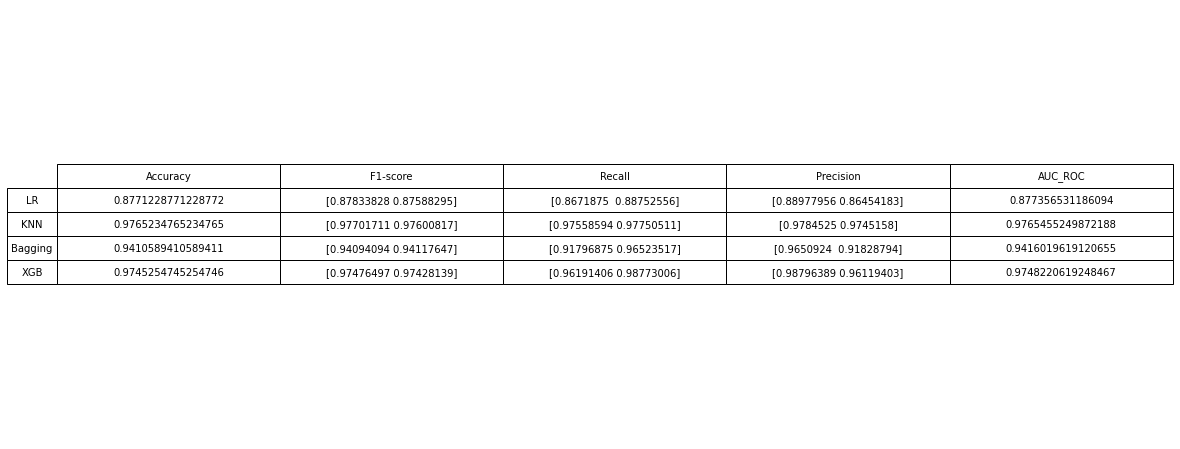

In [33]:
#列名
col=result_df.columns.tolist()

#行名
row=result_df.index.tolist()

#表格里面的具体值
vals=result_df.values.tolist()


plt.figure(figsize=(20,8))
tab = plt.table(cellText=vals, 
              colLabels=col, 
             rowLabels=row,
              loc='center', 
              cellLoc='center',
              rowLoc='center')
tab.scale(1,2) 
plt.axis('off')

### 绘制学习曲线

In [24]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(models, names, X, y, ylim=None, cv=None, n_jobs=-1):
    f, ax = plt.subplots(4, 1, figsize=(20, 50))
    if ylim is not None:
        plt.ylim(*ylim)
    for i in range(len(models)):
        train_sizes, train_scores, test_scores = learning_curve(models[i], X, y, cv=cv, n_jobs=n_jobs)

        train_scores_mean = np.mean(train_scores, axis=1)

        test_scores_mean = np.mean(test_scores, axis=1)

        ax[i].plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label='Training score')
        ax[i].plot(train_sizes, test_scores_mean, '+-', color='#2492ff', label='cross-validation score')

        ax[i].set_title(names[i], fontsize=14)
        ax[i].set_xlabel('Training size(m)')
        ax[i].set_ylabel('Score')
        ax[i].grid(True)
        ax[i].legend(loc='best')

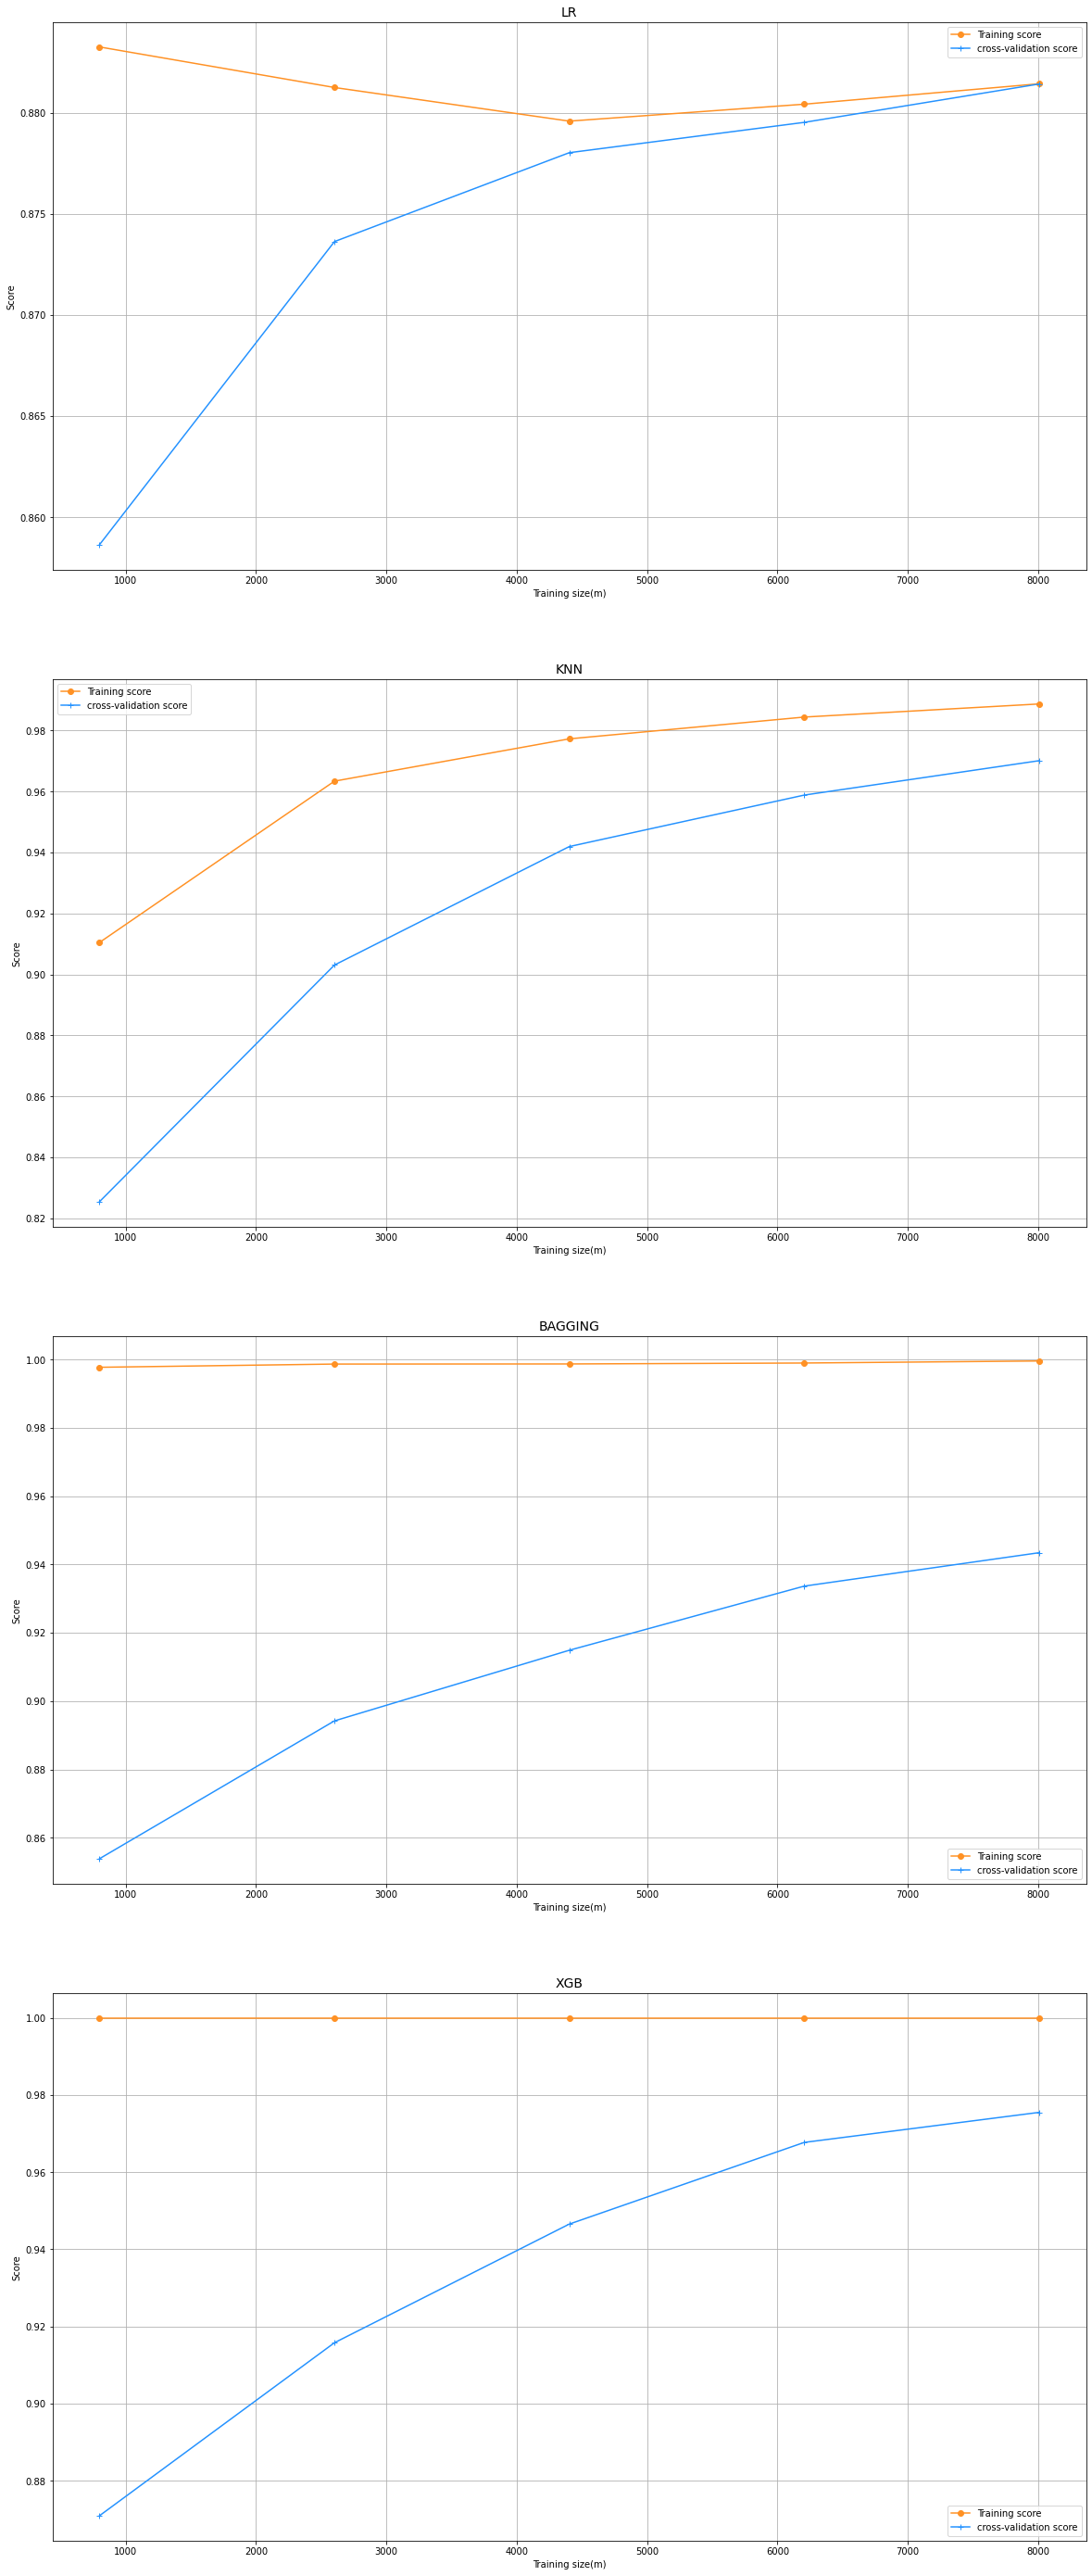

In [25]:
# 切分的比例
cv = ShuffleSplit(n_splits=5, random_state=1, test_size=0.2) 

# 绘制各个模型的学习曲线
best_models = [LR_best_estimator, KNN_best_estimator,BAG_best_estimator, XGB_best_estimator]
names = ['LR', 'KNN', 'BAGGING', 'XGB']

plot_learning_curve(best_models, names, X, y, cv=cv)

### 绘制ROC曲线

In [26]:
from sklearn.model_selection import cross_val_predict

LR_pred = cross_val_predict(LR_best_estimator, X, y)
KNN_pred = cross_val_predict(KNN_best_estimator, X, y)
BAG_pred = cross_val_predict(BAG_best_estimator, X, y)
XGB_pred = cross_val_predict(XGB_best_estimator, X, y)

In [27]:
# 计算auc的评分
print('LR roc_auc_score :', roc_auc_score(y, LR_pred))
print('KNN roc_auc_score :', roc_auc_score(y, KNN_pred))
print('BAG_score :', roc_auc_score(y, BAG_pred))
print('XGB_score :', roc_auc_score(y, XGB_pred))

LR roc_auc_score : 0.878313643056675
KNN roc_auc_score : 0.97002655378407
BAG_score : 0.9453550203078314
XGB_score : 0.9794217556561549


c:\Users\MACHENIKE\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='AUC_ROC'>

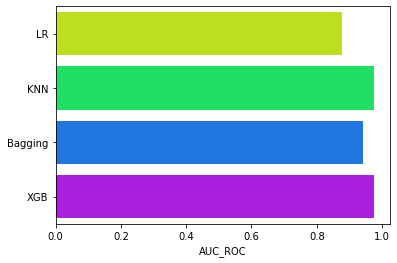

In [34]:
# 可视化 AUC的评分
sns.barplot('AUC_ROC', result_df.index, data=result_df, palette='hsv', orient='h')

In [35]:
# 计算每个模型的 fpr, tpr
from sklearn.metrics import roc_curve

LR_fpr, LR_tpr, LR_threshold = roc_curve(y, LR_pred)

KNN_fpr, KNN_tpr, KNN_threshold = roc_curve(y, KNN_pred)

BAG_fpr, BAG_tpr, BAG_threshold = roc_curve(y, BAG_pred)

XGB_fpr, XGB_tpr, XGB_threshold = roc_curve(y, XGB_pred)

In [36]:
# 绘制roc曲线
def graph_roc(fpr, tpr, name, score):
    plt.figure(figsize=(16,8)) # 画布大小
    plt.title("ROC Curve", fontsize=14)
    plt.plot(fpr, tpr, label=name+":"+ str(score))
    plt.axis([-0.01, 1, 0, 1]) # 坐标轴
    plt.xlabel("False Positive Rate (FPR)", fontsize=14)
    plt.ylabel("True Positive Rate (TPR)", fontsize=14)
    plt.legend()
    plt.show()

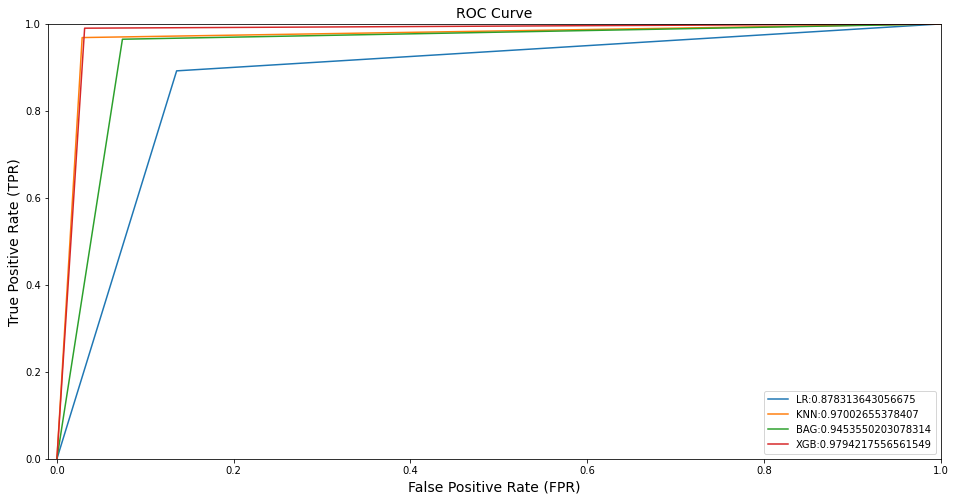

In [37]:
plt.figure(figsize=(16,8)) # 画布大小
plt.title("ROC Curve", fontsize=14)
plt.plot(LR_fpr, LR_tpr, label="LR:"+ str( roc_auc_score(y, LR_pred)))
plt.plot(KNN_fpr, KNN_tpr, label="KNN:"+ str( roc_auc_score(y, KNN_pred)))
plt.plot(BAG_fpr, BAG_tpr, label="BAG:"+ str( roc_auc_score(y, BAG_pred)))
plt.plot(XGB_fpr, XGB_tpr, label="XGB:"+ str( roc_auc_score(y, XGB_pred)))
plt.axis([-0.01, 1, 0, 1]) # 坐标轴
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR)", fontsize=14)
plt.legend()
plt.show()